In [ ]:
import importlib
import render_inference_result
importlib.reload(render_inference_result)
import os
import glob

result_dir = '/data/jhahn/data/shape_dataset/inference_results/inference/brain_block_for_brain_block'

result_dir_list = []
for f in os.listdir(result_dir):
    if os.path.isdir(result_dir+"/"+f):
        result_dir_list.append(result_dir+"/"+f)

data_dir = '/data/jhahn/data/shape_dataset/data'
output_dir = 'output'
#os.makedirs(output_dir, exist_ok=False)

for _result_dir in result_dir_list:
    render_inference_result.make_video(data_dir,_result_dir,output_dir )



In [2]:
d = result_dir+"/0"

d.rsplit("/",1)[1]

'0'

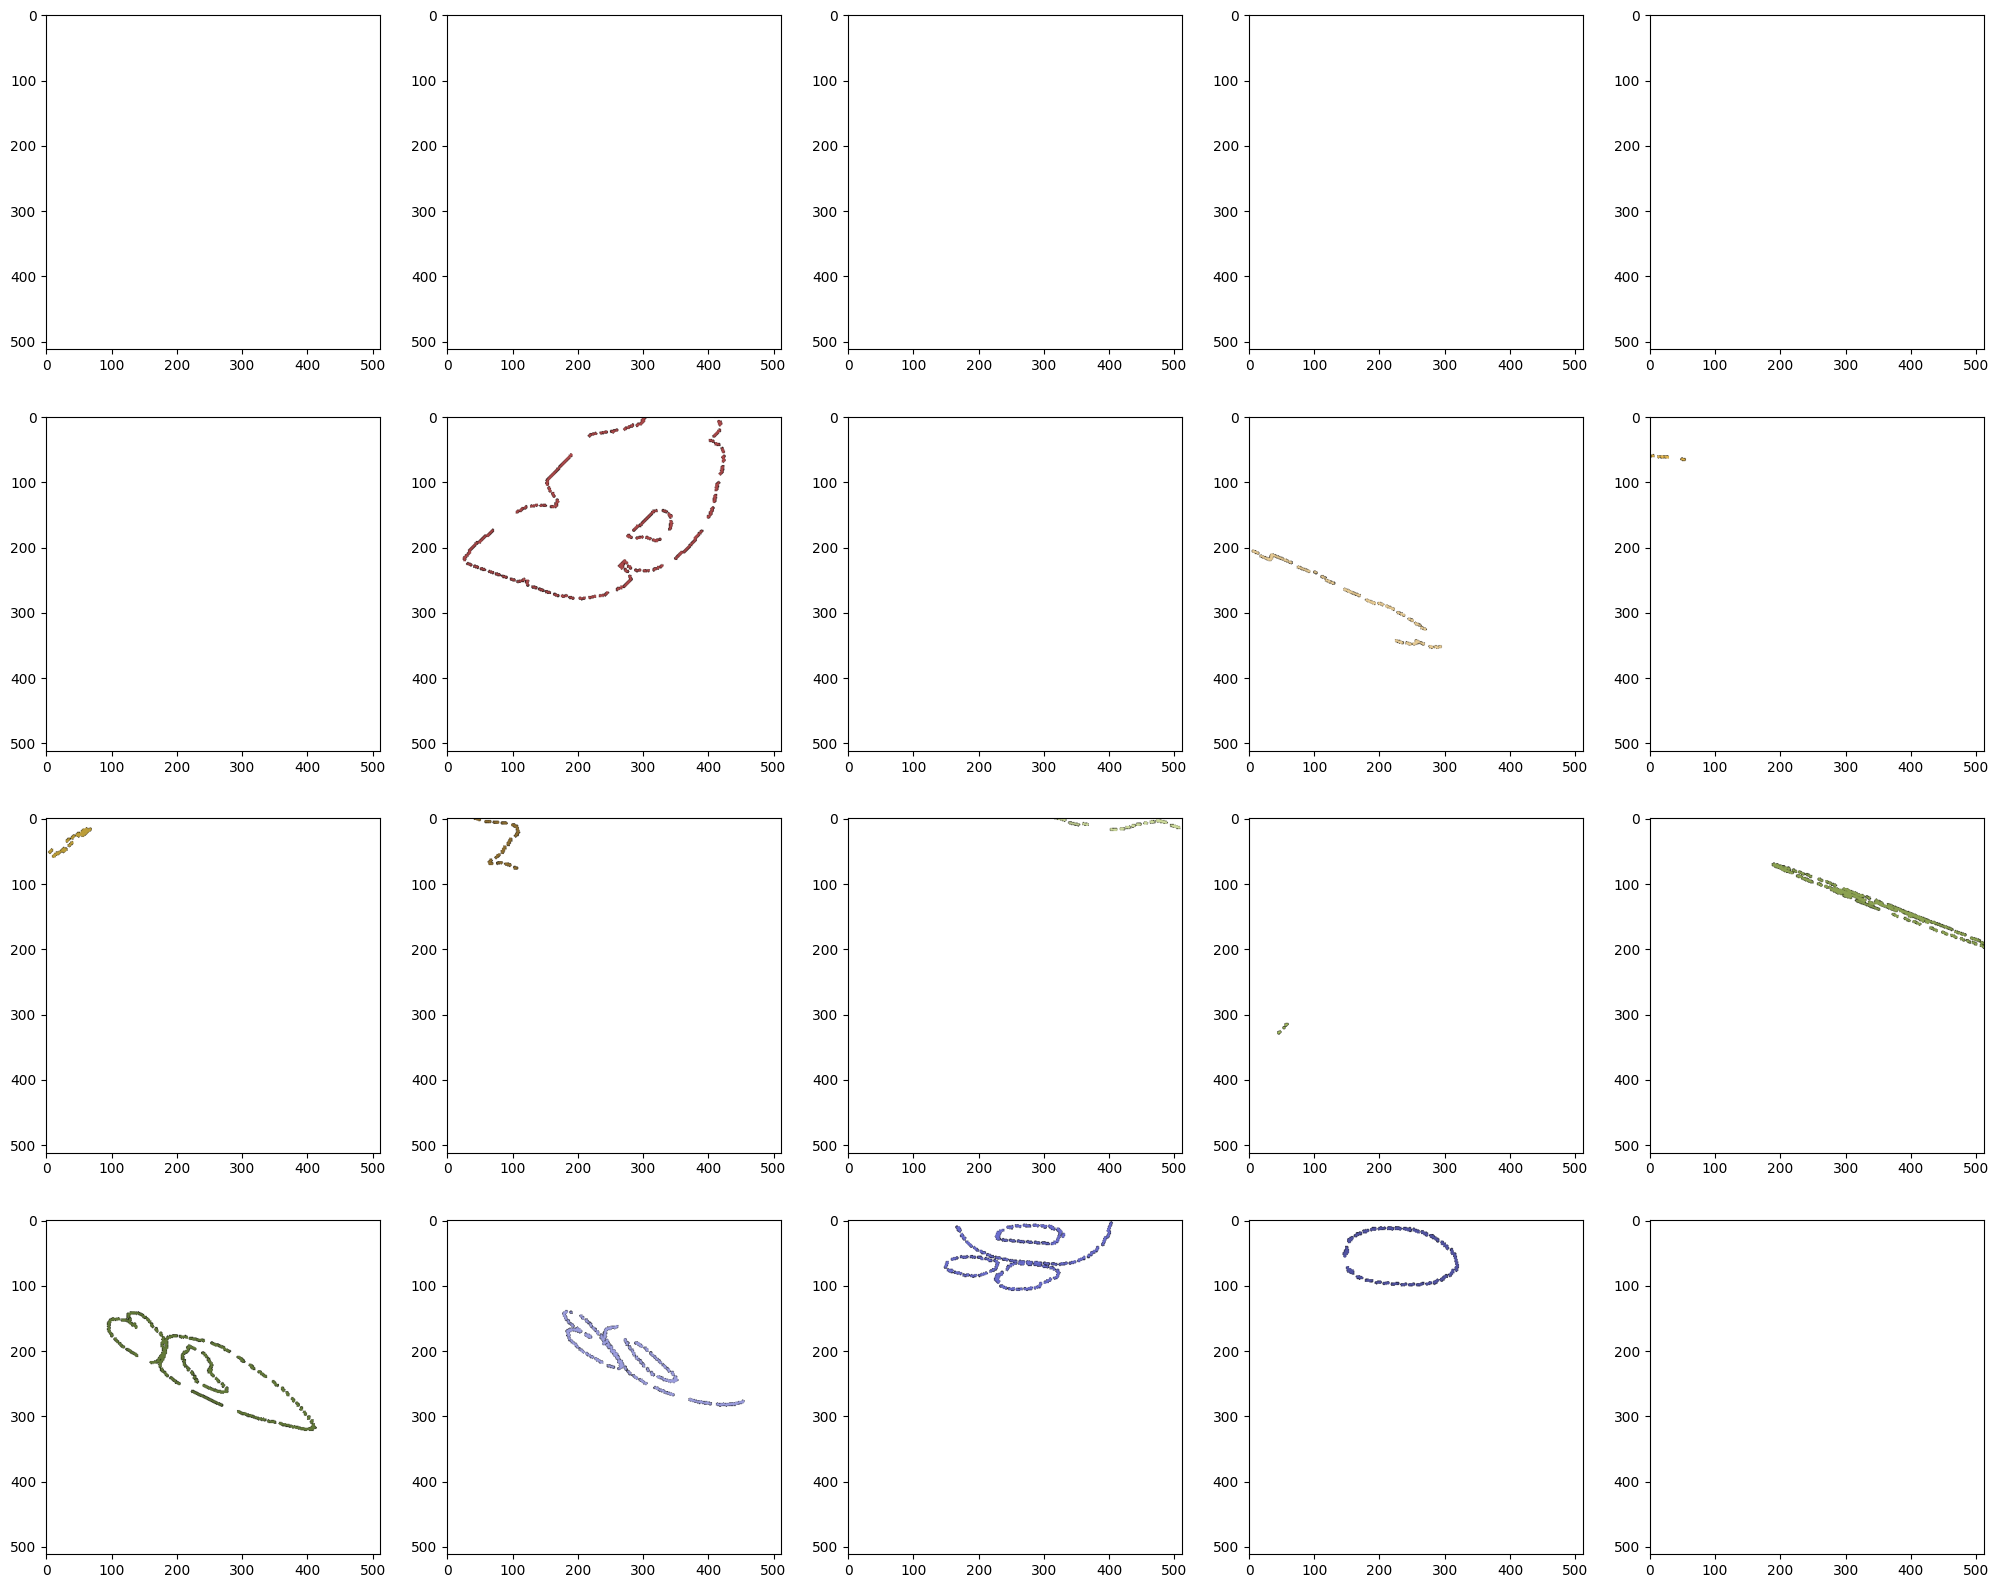

ValueError: need at least one array to stack

In [26]:
def plot_pointcloud2(
    vertices_list,
    alpha=.8,
    title=None,
    max_points=10000,
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1)
    ):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """


    image_size = 512
    radius = 0.01
    points_per_pixel = 50
    R, T = look_at_view_transform(10, 20, 90)
    cameras = FoVOrthographicCameras( device=device, R=R, T=T, znear=100, zfar=-1200, min_x=-12000, max_x=1000, min_y=-15000, max_y=5000)
    #cameras = FoVOrthographicCameras( device=device, R=R, T=T)

    raster_settings = PointsRasterizationSettings(
        image_size=image_size, 
        radius = radius,
        points_per_pixel = points_per_pixel
    )

    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)

    renderer = pytorch3d.renderer.PointsRenderer(
        rasterizer=rasterizer,
        compositor=pytorch3d.renderer.AlphaCompositor(background_color=(1, 1, 1))
        #compositor=NormWeightedCompositor()
    )
    
    fig = plt.figure(figsize=(25,20))

    
    # ax.set_axis_off()
    frames = []
    for _i, vertices  in enumerate(vertices_list):

        
        vertices = vertices.cpu()

        N, dim = vertices.shape

        if N > max_points:
            vertices = np.random.default_rng().choice(vertices, max_points, replace=False)
        
        tr = Translate(torch.FloatTensor([-gt[_i,:3]]))
        rr = Rotate(quaternion_to_matrix(torch.FloatTensor([-gt[_i,3:]])))
        t = Transform3d().compose(tr).compose(rr)
        translated_points = t.transform_points(vertices).to(torch.float).to(device)
        
        #translated_points = vertices.to(device)
        colors = torch.ones_like(translated_points) * torch.tensor(tab10_r.colors[_i%20][:3]).to(device)  # blue points
        point_cloud = pytorch3d.structures.Pointclouds(points=[translated_points], features=[colors.to(torch.float)])

        images = renderer(point_cloud)
        ax = fig.add_subplot(4, 5, _i+1)
        ax.imshow(images[0, ..., :3].cpu().numpy())

        _arr = images[0].cpu().numpy()*255
        _arr = _arr.astype(np.uint8)
        #frames.append(_arr)
        imageio.mimsave(f'output/{_i}.png', [_arr], format='PNG')



    plt.show(fig)
    imageio.mimsave('point_cloud_animation.gif', frames, format='GIF', **{'duration':0.001})
    


    w = iio.get_writer('my_video.mp4', format='FFMPEG', mode='I', fps=2,
                        #codec='h264_vaapi',
                        pixelformat='yuv420p')
    for _i in range(20):
        w.append_data(iio.imread(f'output/{_i}.png'))

    w.close()


mesh_file_dir = '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/'
_files = os.listdir(mesh_file_dir)
mesh_file_list = []
for f in _files:
    if f.endswith(".obj"):
        mesh_file_list.append(mesh_file_dir+f)

mesh_file_list = sorted(mesh_file_list, key=lambda x: int(x.split(".")[-2].split("_")[-1]))
verts_list = []
for mesh_file in mesh_file_list:
    #print(mesh_file)
    mesh = pytorch3d.io.load_obj(mesh_file, device=device)
    verts_list.append(mesh[0])

#plot_pointcloud2(verts,xlim=(0, 1), ylim=(0, 0.9), zlim=(0, 1))
pcd = plot_pointcloud2(verts_list,xlim=(-9000, 0), ylim=(-9000, 0), zlim=(-9000, 0))

['/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_0.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_1.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_2.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_3.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_4.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_5.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_6.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_7.obj',
 '/data/jhahn/data/shape_dataset/data/mouse_brain_50mm/50_tickness_20_sllices_test/fractured_0/piece_8.obj',
 '/data/jhahn/data/

"\ncommand = [\n    '/usr/bin/ffmpeg', \n    '-framerate', f'{frame / 8}',  \n    '-i', f'{imgs_path}/%04d.png',  # Adjust the pattern based on how your frames are named\n    #'-vf', 'tpad=stop_mode=clone:stop_duration=2',  # Hold the last frame for 2 seconds\n    #'-c:v', 'libx264', \n    '-pix_fmt', 'yuv420p', \n    #'-crf', '17',  # Adjust CRF (lower means higher quality)\n    video_path\n]\nsubprocess.run(command, check=True)\n"

In [86]:
import imageio
import numpy as np

# Create a sequence of dummy images (e.g., a red square moving across a black background)
num_frames = 20
image_size = 64
images = []
for i in range(num_frames):
    img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    x = int(i * (image_size / num_frames))
    img[x:x + 10, x:x + 10, 0] = 255  # Red square
    print(img.shape)
    print(img)
    images.append(img)

# Save the sequence as a GIF
imageio.mimsave('moving_square.gif', images, duration=0.1)

(64, 64, 3)
[[[255   0   0]
  [255   0   0]
  [255   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255   0   0]
  [255   0   0]
  [255   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255   0   0]
  [255   0   0]
  [255   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(64, 64, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]



(0, 0, 0)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
torch.Size([512, 512, 3])
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 

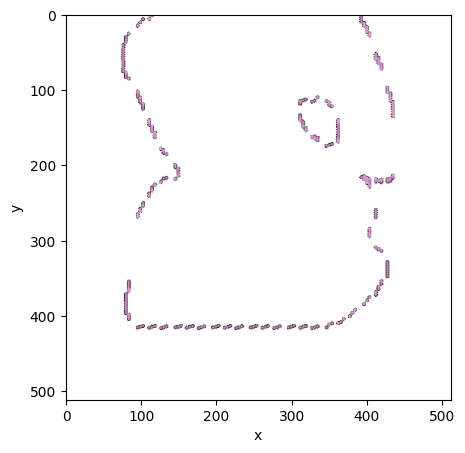

In [ ]:

image_size = 512
radius = 0.01
points_per_pixel = 50
R, T = look_at_view_transform(1, 30, 90)
cameras = FoVOrthographicCameras( device=device, R=R, T=T, znear=-1000, zfar=0, min_x=-9000, max_x=1000, min_y=-5000, max_y=1000)
#cameras = FoVOrthographicCameras( device=device, R=R, T=T)

raster_settings = PointsRasterizationSettings(
    image_size=image_size, 
    radius = radius,
    points_per_pixel = points_per_pixel
)

rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)

renderer = pytorch3d.renderer.PointsRenderer(
    rasterizer=rasterizer,
    compositor=pytorch3d.renderer.AlphaCompositor(background_color=(1, 1, 1))
    #compositor=NormWeightedCompositor()
)







translated_points = pytorch3d.io.load_obj(mesh_file_dir+'piece_11.obj', device=device)[0]

_i = 0
this_color = tab10_r.colors[_i%20][:3]
this_color = (0,0,0)
print(this_color)
colors = torch.ones_like(translated_points) * torch.tensor(tab10_r.colors[_i%20][:3]).to(device)  # blue points
point_cloud = pytorch3d.structures.Pointclouds(points=[translated_points], features=[colors.to(torch.float)])
#print(translated_points)
#print(colors)
#return point_cloud
# Update point cloud object
#point_cloud.update(points=[rotated_points])

frames = []
# Render frame
#images = renderer(point_cloud, cameras=camera)
#print(translated_points.shape,translated_points)
#print(np.max(translated_points, axis=0),np.min(translated_points, axis=0))
img = renderer(point_cloud)
_arr = img[0].cpu().numpy()*255
_arr = _arr.astype(np.uint8)
print(_arr)
frames.append(_arr)
print(img[0].shape)
print(img[0].cpu().numpy()*255)
#print(img.reshape(image_size,image_size).shape)
print(img[img != 1])
print((img != 1).sum())
print(points.shape)
#points = sample_points_from_meshes(mesh, 5000)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.imshow(img[0, ..., :3].cpu().numpy())

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()
    

imageio.mimsave('moving_square.gif', frames, duration=0.1)
#mesh = pytorch3d.io.load_obj('piece_1.obj', device=device)
#verts = mesh[0]

#plot_pointcloud_basic(verts,xlim=(0, 1), ylim=(0, 0.9), zlim=(0, 1))

In [20]:
import torch
import pytorch3d.structures
import pytorch3d.renderer
import imageio
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
# Generate a sample point cloud
num_points = 1000
points = torch.rand(num_points, 3)
colors = torch.ones_like(points) * torch.tensor([0.7, 0.7, 1.0])  # blue points

# Create Pointclouds object


# Set up renderer
image_size = 256
radius = 0.01
points_per_pixel = 1
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)
raster_settings = PointsRasterizationSettings(
    image_size=image_size, 
    radius = radius,
    points_per_pixel = points_per_pixel
)

rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)

renderer = pytorch3d.renderer.PointsRenderer(
    rasterizer=rasterizer,
    compositor=pytorch3d.renderer.AlphaCompositor()
)

# Define camera
camera = pytorch3d.renderer.FoVPerspectiveCameras()

# Animation loop
num_frames = 30
frames = []
for i in range(num_frames):
    # Update point positions (example: rotate around y-axis)
    angle = torch.tensor([i * 2 * 3.14159 / num_frames])
    rot_matrix = torch.tensor([[torch.cos(angle), 0, torch.sin(angle)],
                                 [0, 1, 0],
                                 [-torch.sin(angle), 0, torch.cos(angle)]])
    rotated_points = torch.matmul(points, rot_matrix.T)
    point_cloud = pytorch3d.structures.Pointclouds(points=[rotated_points], features=[colors])
    # Update point cloud object
    #point_cloud.update(points=[rotated_points])

    # Render frame
    images = renderer(point_cloud, cameras=camera)
    frame = (images[0, ..., :3].cpu().numpy() * 255).astype('uint8')
    frames.append(frame)

# Save animation as GIF
imageio.mimsave('point_cloud_animation.gif', frames, fps=20)

In [3]:
img_resolution = (256, 256)

raster_settings = RasterizationSettings(
    image_size=img_resolution,
    bin_size=None,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[-2.0, -2.0, -5.0]])

materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0
)

rasterizer=MeshRasterizer(raster_settings=raster_settings)

# Set up a renderer.
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=HardPhongShader(device=device, lights=lights)
)

In [4]:
def load_mesh(obj_file_path, device="cuda"):
    mesh = load_objs_as_meshes([obj_file_path], device=device)
    verts, faces = mesh.get_mesh_verts_faces(0)
    texture_rgb = torch.ones_like(verts, device=device)
    texture_rgb[:, 1:] *= 0.0  # red, by zeroing G and B
    mesh.textures = Textures(verts_rgb=texture_rgb[None])
    
    # Normalize mesh
    verts = verts - verts.mean(dim=0)
    verts /= verts.max()
    
    # This updates the pytorch3d mesh with the new vertex coordinates.
    mesh = mesh.update_padded(verts.unsqueeze(0))
    verts, faces = mesh.get_mesh_verts_faces(0)
    
    return mesh, verts, faces    

In [5]:
mesh_file_path = "output.obj"
mesh, verts, faces = load_mesh(mesh_file_path)

print(
    f"Loaded Mesh from : {mesh_file_path}"
    f"\nVertices: {verts.shape}"
    f"\nFaces: {faces.shape}"
)

# IGNORE Warnings and AttributeError if any

/data/jhahn/slice_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


ValueError: Split size must be of same length as inputs first dimension

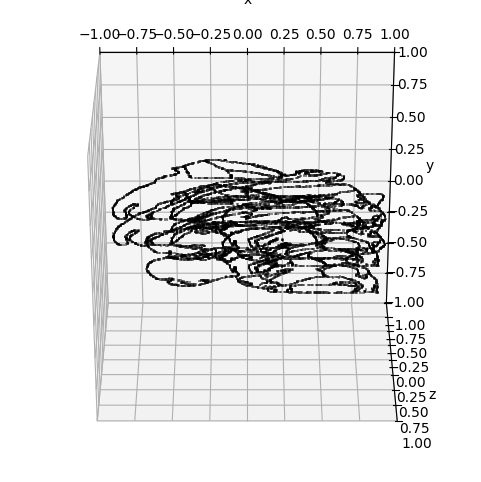

In [23]:
plot_pointcloud(verts)

In [8]:
mesh_center = torch.tensor([0.0, 0.0, 0.0], device=device)

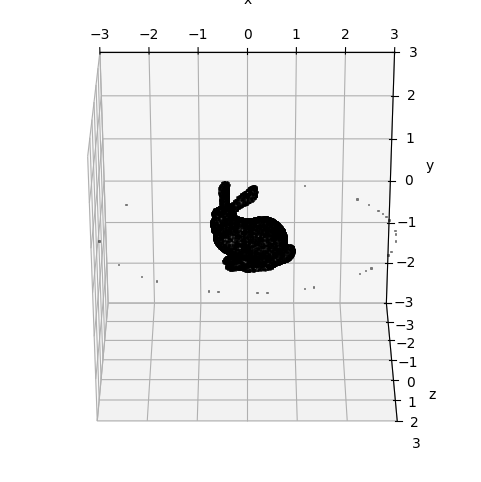

In [9]:
points = generate_camera_locations(mesh_center, 3, 100)

plot_pointcloud(torch.cat((points, verts), dim=0), xlim=(-3, 3), ylim=(-3, 3), zlim=(-3, 3))

In [10]:
R_pt3d, T_pt3d = get_look_at_views(points, mesh_center.repeat(points.shape[0], 1))

In [11]:
K_pt3d = torch.tensor([[0.7, 0., 0.5, 0.],
                        [0., 0.7, 0.5, 0.],
                        [0., 0., 0., 1.0],
                        [0., 0., 1., 0.]], device=device)

K_pt3d

tensor([[0.7000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.7000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000]], device='cuda:0')

In [12]:
# Reconstruction

image_size = torch.tensor([img_resolution])
K = K_pt3d.unsqueeze(0)
all_meshes = list()

for idx in tqdm(range(len(points)), desc="Processing meshes"):
    # Initialize matrices
    R = R_pt3d[idx].unsqueeze(0)
    T = T_pt3d[idx].unsqueeze(0)
    
    # Define Camera
    cam = pytorch3d.renderer.cameras.PerspectiveCameras(
        R=R, 
        T=T,
        K=K,
        in_ndc=False, 
        image_size=[(1,1)],
        device=device
    )
    
    # Render image
    images = renderer(mesh, cameras=cam, lights=lights)
    image = images[0]
    
    # Depth
    fragments = rasterizer(mesh, cameras=cam)
    depths = fragments.zbuf
    depth = depths[0]
    
    #Back-Projection
    xy_pix = get_normalized_pixel_coordinates_pt3d(img_resolution[0], img_resolution[1], device=device)
    xy_pix = xy_pix.flatten(0, -2)
    depth = depth.flatten(0, -2)
    xyz = torch.cat((xy_pix, depth), dim=1)
    world_points = cam.unproject_points(xyz)    
        
    # Replacing Nan with zeros
    world_points = torch.where(torch.isnan(world_points), torch.zeros_like(world_points), world_points)
    world_points = world_points[depth.squeeze()!=-1, :]

    
    num_points, _ = world_points.shape
    H = int((num_points + 1) ** 0.5)
    W = int(num_points / H)    
    
    # Triangulation
    triangulated_mesh = get_mesh(world_space_points=world_points.T, depth=depth, H=H, W=W)

    # Append Mesh
    all_meshes.append(triangulated_mesh)

Processing meshes: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


In [13]:
def simplify_mesh(mesh):
    voxel_size = 0.02
    device = "cuda"
    v = mesh.vertices
    f = mesh.faces
    dtype_v = v.dtype
    dtype_f = f.dtype
    m = o3d.geometry.TriangleMesh()
    m.vertices      = o3d.utility.Vector3dVector(v.astype(np.float64))
    m.triangles     = o3d.utility.Vector3iVector(f.astype(np.int32  ))
    m = m.simplify_vertex_clustering(voxel_size=voxel_size)
    v = np.asarray(m.vertices     ).astype(dtype_v)
    f = np.asarray(m.triangles    ).astype(dtype_f)
    v = torch.from_numpy(v).to(device=device)
    f = torch.from_numpy(f).to(device=device)
    
    mesh = trimesh.Trimesh(
        vertices = v.cpu(),
        faces = f.cpu()
    )
    return mesh

In [14]:
def merge_mesh(mesh1, mesh2):
    v1 = torch.tensor(mesh1.vertices)
    f1 = torch.tensor(mesh1.faces)
    
    v2 = torch.tensor(mesh2.vertices)
    f2 = torch.tensor(mesh2.faces)    
    
    v = torch.cat([v1, v2], dim=0)
    f = torch.cat([f1, f2 + len(v1)], dim=0)
    
    merged_mesh = trimesh.Trimesh(
        vertices = v.cpu().numpy(),
        faces = f.cpu().numpy()
    )
    
    return merged_mesh

In [16]:
# save combined mesh
mesh_combined = all_meshes[0]
for m in all_meshes[1:]:
    mesh_combined = merge_mesh(mesh_combined, m)
    # mesh_combined = simplify_mesh(mesh_combined) 

save_mesh(mesh_combined, "combined_mesh.ply")